Reshaped data shape (after transpose): (9, 3594000)
Number of blocks detected: 12
Lengths of detected blocks (in seconds): [0.3, 0.09785, 2.99785, 0.99785, 0.09785, 2.99785, 0.99785, 0.29785, 0.29785, 2.99785, 0.99785, 0.09785]


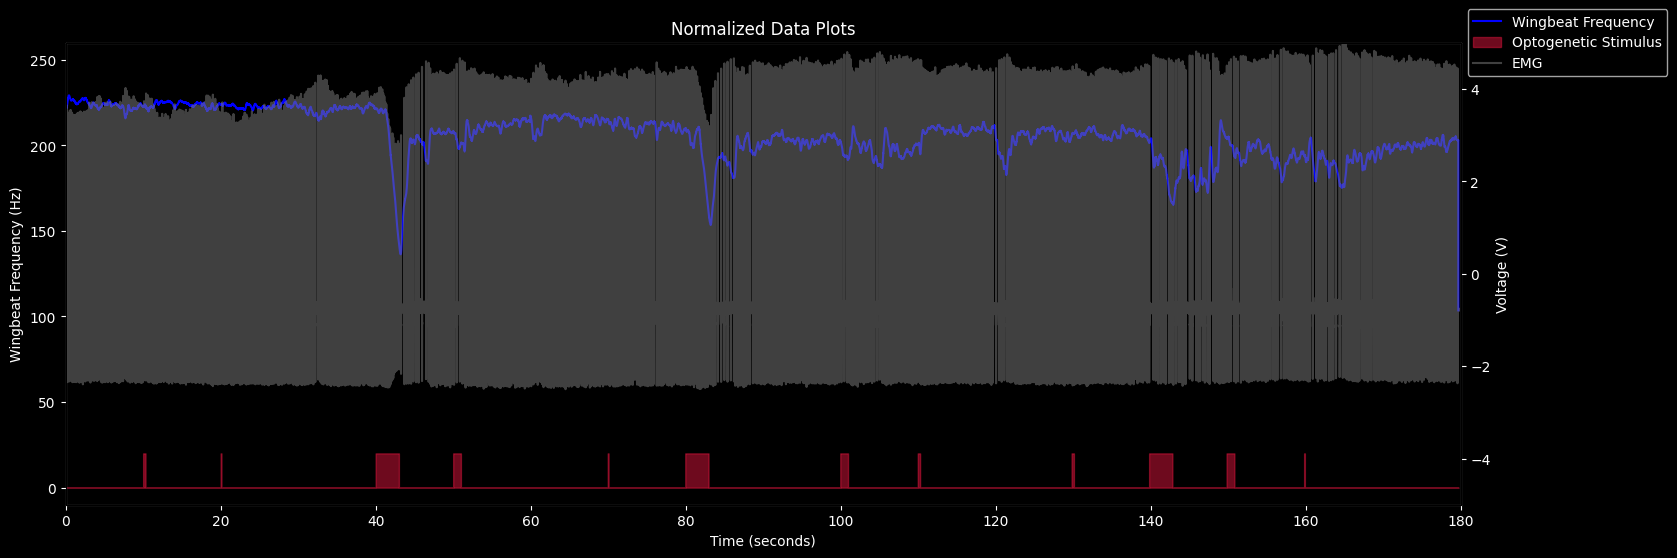

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

wingbeat_freq = []
spike_raw = []
opto_stim = []
sampling_rate = 20000
file_path = '/Users/camellyc/Downloads/spMN2_ChR_VT029591_R20F02_4d_F_Fly1_Trial21_0-3000ms_2024_1001_170528_another_unit_maximum_intensity'

# Run the main function
if __name__ == "__main__":
    spikes_WBF_opto()

# Main function to execute all steps
def spikes_WBF_opto():
    global wingbeat_freq
    global spike_raw
    global opto_stim
    
    # Specify the file path
    global file_path 

    # Load and reshape the data
    data = load_and_reshape_data(file_path)

    # Extract relevant traces
    wingbeat_freq, spike_raw, opto_stim = extract_traces(data)

    # Smooth data4
    wingbeat_freq_smoothed = smooth_data(wingbeat_freq)

    # Normalize data
    wingbeat_freq_normalized = normalize_data(wingbeat_freq_smoothed, -10, 260, -0.1, 2.6)
    spike_normalized = normalize_data(spike_raw, -2.5, 5)

    # Generate time axis
    time = generate_time_axis(wingbeat_freq.shape[0])

    # Transform opto stimulus data
    transformed_opto_stim = transform_opto_stimulus(opto_stim)

    # Plot the data
    plot_data(time, wingbeat_freq_normalized, spike_normalized, transformed_opto_stim)

    return wingbeat_freq, spike_raw, opto_stim

# Function to load and reshape data from binary file
def load_and_reshape_data(file_path):
    try:
        # Read binary file into a NumPy array and reshape it
        with open(file_path, 'rb') as fid:
            data = np.fromfile(fid, dtype=np.float64).reshape(-1, 9).T
        print(f"Reshaped data shape (after transpose): {data.shape}")
        return data
    except FileNotFoundError:
        raise Exception(f"Failed to open file at {file_path}")

# Function to extract relevant traces from the data
def extract_traces(data):
    wingbeat_freq = data[3, :]  # 4th row for WBF data
    spike_raw = data[5, :]  # 6th row for spike data
    opto_stim = data[6, :]  # 7th row for opto stim
    return wingbeat_freq, spike_raw, opto_stim

# Function to smooth data using a sliding window
def smooth_data(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Function to normalize data
def normalize_data(data, new_min, new_max, old_min=None, old_max=None):
    if old_min is None:
        old_min = np.min(data)
    if old_max is None:
        old_max = np.max(data)
    return (data - old_min) * (new_max - new_min) / (old_max - old_min) + new_min

# Function to transform opto stimulus data
import numpy as np

def transform_opto_stimulus(data7):
    global sampling_rate
    transformed_data7 = np.zeros_like(data7)
    stim_on = False
    stim_start_idx = 0
    max_pulse_gap_samples = int(30 * sampling_rate / 1000)  # 30 ms gap = 600 samples
    
    block_lengths = []  # List to store lengths of detected blocks
    block_count = 0     # Counter for number of blocks
    last_stim_end_idx = -1  # Track the end of the last detected pulse, initialized to -1 for validation

    for i in range(1, len(data7)):
        if data7[i] >= 0.9 and not stim_on:  # Detect the start of a pulse
            if stim_start_idx == 0:
                stim_start_idx = i  # Start a new stimulus block
            stim_on = True
        elif data7[i] < 1 and stim_on:  # Detect the end of a pulse
            stim_on = False
            last_stim_end_idx = i  # Update the last pulse end index

        # If a block is active and the gap between pulses is greater than 30 ms, close the block
        if stim_start_idx != 0 and (last_stim_end_idx != -1) and (i - last_stim_end_idx > max_pulse_gap_samples):
            if last_stim_end_idx > stim_start_idx:  # Ensure block length calculation is valid
                transformed_data7[stim_start_idx:last_stim_end_idx] = 1  # Mark the block
                block_length = last_stim_end_idx - stim_start_idx  # Calculate block length
                block_lengths.append(block_length)  # Store block length
                block_count += 1  # Increment block count
            stim_start_idx = 0  # Reset for the next block

    # Final check in case the last block continues until the end
    if stim_start_idx != 0 and last_stim_end_idx > stim_start_idx:
        transformed_data7[stim_start_idx:last_stim_end_idx] = 1
        block_length = last_stim_end_idx - stim_start_idx  # Calculate block length
        block_lengths.append(block_length)  # Store block length
        block_count += 1  # Increment block count
    
    block_lengths_in_seconds = [length / sampling_rate for length in block_lengths]  # Convert each block length to seconds

    # Output the number and length of detected blocks
    print(f"Number of blocks detected: {block_count}")
    print(f"Lengths of detected blocks (in seconds): { block_lengths_in_seconds}")

    return transformed_data7

# Function to generate a time axis
def generate_time_axis(data_length):
    global sampling_rate
    return np.arange(data_length) / sampling_rate

# Function to plot the data
def plot_data(time, data4_normalized, data6_normalized, transformed_data7):
    fig, ax1 = plt.subplots(figsize=(18, 6), facecolor='k')
    ax1.set_facecolor('k')

    # Plot data4 on the left y-axis
    ax1.plot(time, data4_normalized, color='blue', linewidth=1.5, label='Wingbeat Frequency')
    ax1.set_xlabel('Time (seconds)', color='w')
    ax1.set_ylabel('Wingbeat Frequency (Hz)', color='w')
    ax1.set_ylim(-10, 260)
    ax1.tick_params(axis='y', colors='w')
    ax1.tick_params(axis='x', colors='w')
    ax1.spines['bottom'].set_color('w')
    ax1.spines['top'].set_color('w')
    ax1.spines['right'].set_color('w')
    ax1.spines['left'].set_color('w')

    # Create a second y-axis for data6
    ax2 = ax1.twinx()
    ax2.plot(time, data6_normalized, color='gray', alpha=0.5, linewidth=1.5, label='EMG')
    ax2.set_ylabel('Voltage (V)', color='w')
    ax2.set_ylim(-5, 5)
    ax2.tick_params(axis='y', colors='w')

    # Plot transformed data7 in crimson with 50% opacity on the first axis (bottom layer)
    ax1.fill_between(time, 0, 20 * transformed_data7, color='crimson', alpha=0.5, label='Optogenetic Stimulus')

    # Adding labels and title
    plt.title('Normalized Data Plots', color='w')
    ax1.set_xlim(0, 180)

    # Adding legend to the right-hand side, outside the plot
    fig.legend(loc='center left', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, facecolor='k', labelcolor='w')

    # Show plot
    plt.show()

Reshaped data shape (after transpose): (9, 3594000)
Number of blocks detected: 12
Lengths of detected blocks (in seconds): [0.3, 0.09785, 2.99785, 0.99785, 0.09785, 2.99785, 0.99785, 0.29785, 0.29785, 2.99785, 0.99785, 0.09785]


Detecting Spikes: 100%|██████████| 3593998/3593998 [00:02<00:00, 1613038.28it/s]


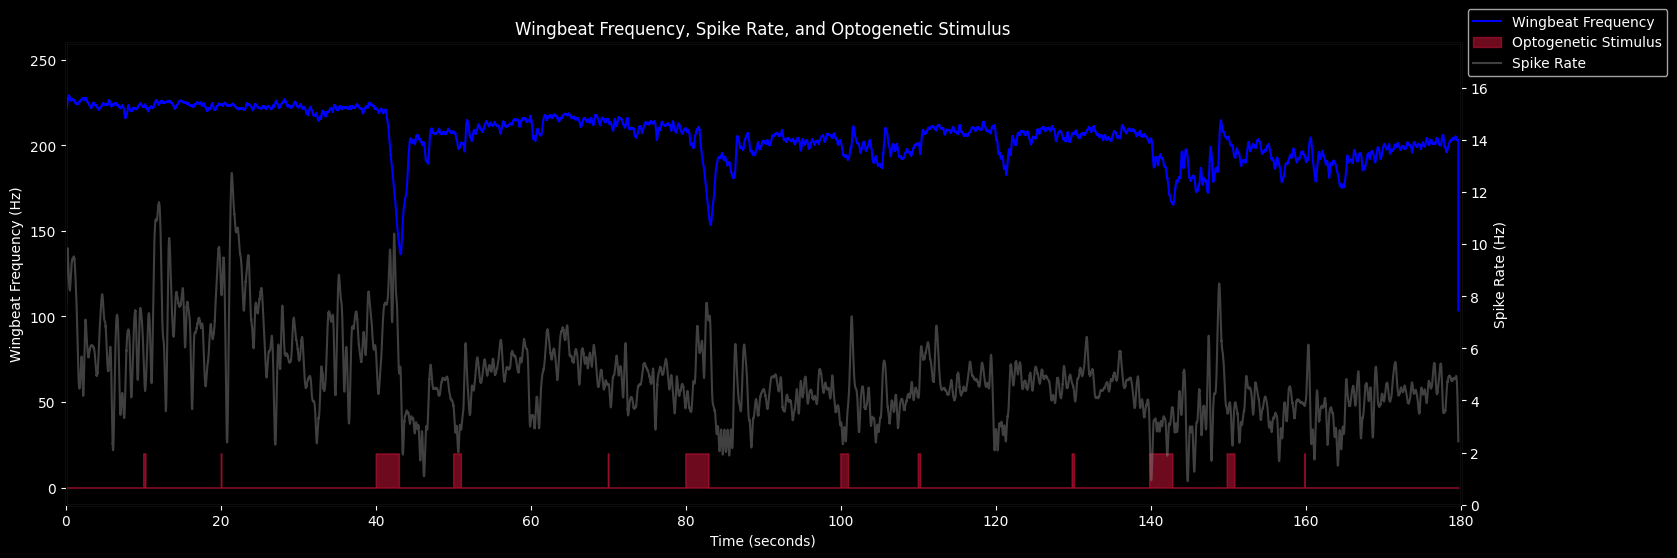

Wingbeat Frequency Smoothed: [1.10904117 1.13122403 1.15341347 1.17558318 1.19776933 1.21995548
 1.24212519 1.26430805 1.28648763 1.30866063]
Spike Raw Data: [ 0.03079671  0.01830617  0.00450083  0.0117322   0.02685233  0.01534788
 -0.00338794  0.00482953  0.01994966  0.00976001]
Optogenetic Stimulus: [0.00219994 0.00219994 0.00187124 0.00154254 0.00252864 0.00154254
 0.00187124 0.00187124 0.00187124 0.00154254]
Spike Rate: [6.26032571 6.2617739  6.26322197 6.26466992 6.26611776 6.26756549
 6.2690131  6.27046059 6.27190796 6.27335522]


In [65]:
# Run the main function
if __name__ == "__main__":
    wingbeat_freq_smoothed, spike_raw, opto_stim, spike_rate = spikerate_WBF_opto()
    print("Wingbeat Frequency Smoothed:", wingbeat_freq_smoothed[:10])  # Display first 10 values for example
    print("Spike Raw Data:", spike_raw[:10])
    print("Optogenetic Stimulus:", opto_stim[:10])
    print("Spike Rate:", spike_rate[:10])

# Main function to execute all steps
def spikerate_WBF_opto():
    # Specify the file path
    global file_path
    
    # Load and reshape the data
    data = load_and_reshape_data(file_path)

    # Extract relevant traces
    wingbeat_freq, spike_raw, opto_stim = extract_traces(data)

    # Smooth and normalize wingbeat frequency
    wingbeat_freq_smoothed = smooth_data(wingbeat_freq)
    wingbeat_freq_normalized = normalize_data(wingbeat_freq_smoothed, -10, 260, -0.1, 2.6)

    # Transform opto stimulus data
    transformed_opto_stim = transform_opto_stimulus(opto_stim)

    # Process spike data and calculate spike rate
    time_in_seconds, spike_rate = process_spikes(spike_raw)

    # Plot the data
    plot_data(time_in_seconds, wingbeat_freq_normalized, spike_rate, transformed_opto_stim)

    return wingbeat_freq_smoothed, spike_raw, opto_stim, spike_rate

# Function to calculate adaptive threshold for spike detection
def calculate_adaptive_threshold(signal, sampling_rate, window_duration_sec=0.5, multiplier=6):
    window_size = int(window_duration_sec * sampling_rate)
    adaptive_threshold = np.array([np.std(signal[max(0, i - window_size):i + window_size]) * multiplier
                                   for i in tqdm(range(len(signal)), desc="Calculating Adaptive Threshold")])
    return adaptive_threshold

# Function to calculate the derivative of the signal
def calculate_derivative(signal):
    return np.diff(signal, prepend=signal[0])

# Function to detect spikes in the signal
def detect_spikes(signal, derivative, adaptive_threshold, sampling_rate, min_spike_distance_ms=10):
    spike_count = np.zeros(len(signal))
    min_distance = int(min_spike_distance_ms * sampling_rate / 1000)  # Convert ms to samples
    last_spike_index = -min_distance  # Initialize last spike index to ensure minimum distance condition is met

    for i in tqdm(range(1, len(signal) - 1), desc="Detecting Spikes"):
        if (derivative[i] > derivative[i - 1] and derivative[i] > derivative[i + 1] and
                abs(signal[i]) > adaptive_threshold[i] and (i - last_spike_index) > min_distance):
            spike_count[i] = 1  # Mark it as a spike
            last_spike_index = i  # Update the last spike index

    return spike_count

# Function to calculate spike rate by convolving spike count with Gaussian kernel
def calculate_spike_rate(spike_count, sampling_rate, target_spike_rate=7.0):
    sigma = sampling_rate / target_spike_rate  # Set sigma to match the desired rate
    kernel_size = int(6 * sigma)  # Kernel size to cover +- 3 sigma
    x = np.linspace(-3 * sigma, 3 * sigma, kernel_size)
    
    # Create and normalize Gaussian kernel
    gaussian_kernel = np.exp(-0.5 * (x / sigma) ** 2)
    gaussian_kernel /= np.sum(gaussian_kernel)
    
    # Convolve spike count with Gaussian kernel to get smooth spike rate
    spike_rate = np.convolve(spike_count, gaussian_kernel, mode='same') * sampling_rate
    return spike_rate

# Function to generate a time axis
def generate_time_axis(signal_length, sampling_rate):
    return np.arange(signal_length) / sampling_rate

# Function to process spikes and calculate spike rate
def process_spikes(spike_raw, target_spike_rate=7.0):
    global sampling_rate
    # Step 1: Calculate adaptive threshold
    adaptive_threshold = calculate_adaptive_threshold(spike_raw, sampling_rate)

    # Step 2: Calculate derivative of the signal
    spike_raw_derivative = calculate_derivative(spike_raw)

    # Step 3: Detect spikes
    spike_count = detect_spikes(spike_raw, spike_raw_derivative, adaptive_threshold, sampling_rate)

    # Step 4: Calculate smoothed spike rate
    spike_rate = calculate_spike_rate(spike_count, sampling_rate, target_spike_rate)

    # Step 5: Generate time axis
    time_in_seconds = generate_time_axis(len(spike_raw), sampling_rate)

    return time_in_seconds, spike_rate

# Function to plot the data
def plot_data(time, data4_normalized, spike_rate, transformed_data7):
    fig, ax1 = plt.subplots(figsize=(18, 6), facecolor='k')
    ax1.set_facecolor('k')

    # Plot data4 on the left y-axis
    ax1.plot(time, data4_normalized, color='blue', linewidth=1.5, label='Wingbeat Frequency')
    ax1.set_xlabel('Time (seconds)', color='w')
    ax1.set_ylabel('Wingbeat Frequency (Hz)', color='w')
    ax1.set_ylim(-10, 260)
    ax1.tick_params(axis='y', colors='w')
    ax1.tick_params(axis='x', colors='w')
    ax1.spines['bottom'].set_color('w')
    ax1.spines['top'].set_color('w')
    ax1.spines['right'].set_color('w')
    ax1.spines['left'].set_color('w')

    # Create a second y-axis for spike rate
    ax2 = ax1.twinx()
    ax2.plot(time, spike_rate, color='gray', alpha=0.5, linewidth=1.5, label='Spike Rate')
    ax2.set_ylabel('Spike Rate (Hz)', color='w')
    ax2.set_ylim(0, np.max(spike_rate) + 5)
    ax2.tick_params(axis='y', colors='w')

    # Plot transformed data7 in crimson with 50% opacity on the first axis (bottom layer)
    ax1.fill_between(time, 0, 20 * transformed_data7, color='crimson', alpha=0.5, label='Optogenetic Stimulus')

    # Adding labels and title
    plt.title('Wingbeat Frequency, Spike Rate, and Optogenetic Stimulus', color='w')
    ax1.set_xlim(0, 180)

    # Adding legend to the right-hand side, outside the plot
    fig.legend(loc='center left', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, facecolor='k', labelcolor='w')

    # Show plot
    plt.show()

/var/folders/tz/5xxpw5x57bg8vtkdkhljt7880000gn/T/ipykernel_6808/2636840710.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/camellyc/Desktop/Codes/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


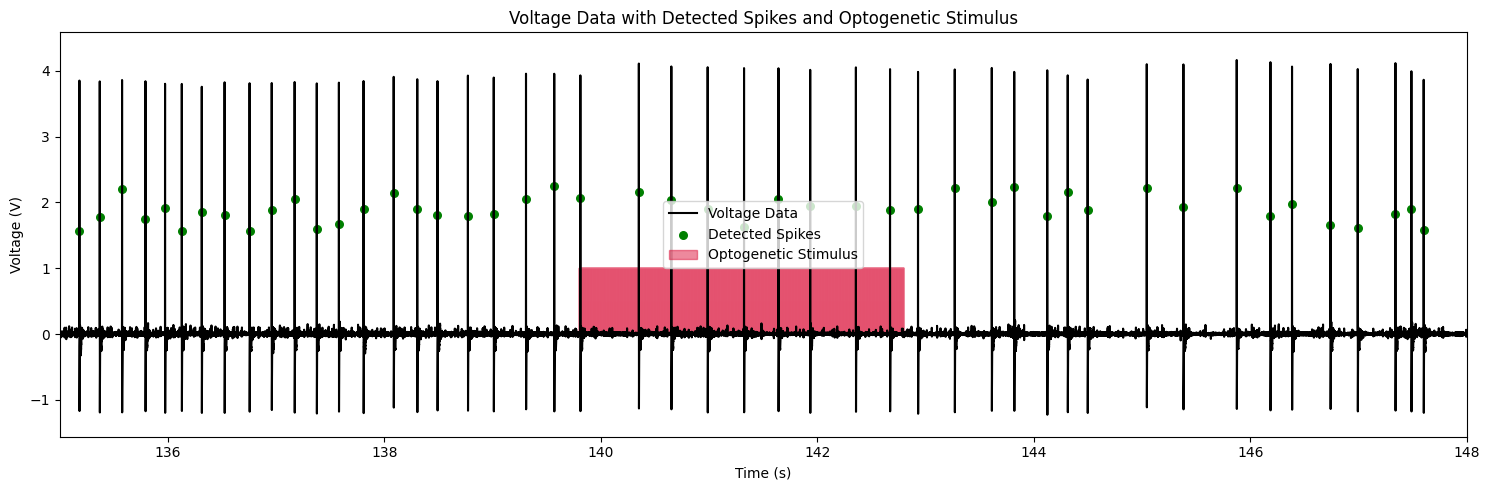

In [66]:
# Section 3: Plot spike train, spike rate, and optogenetic stimulus
def plot_spike_train(time_in_seconds, data6, spike_count, transformed_data7, xlimit=(135, 148)):
    """
    Plots the voltage data with detected spikes and optogenetic stimulus overlay.
    
    Args:
    - time_in_seconds: Array representing time in seconds.
    - data6: Voltage data (signal) to be plotted.
    - spike_count: Binary array indicating spike events.
    - transformed_data7: Array representing the optogenetic stimulus.
    - xlimit: Tuple representing the x-axis limits for the plot (default is (135, 148)).
    """
    fig, ax1 = plt.subplots(1, figsize=(15, 5))

    # Plot the original voltage data with detected spikes
    ax1.plot(time_in_seconds, data6, label='Voltage Data', color='black')
    ax1.scatter(time_in_seconds[np.where(spike_count == 1)[0]], 
                data6[np.where(spike_count == 1)[0]], 
                color='green', label='Detected Spikes', s=30)
    
    # Fill between for optogenetic stimulus
    ax1.fill_between(time_in_seconds, 0, transformed_data7, color='crimson', alpha=0.5, label='Optogenetic Stimulus', zorder=0)

    # Set labels, title, and limits
    ax1.set_title('Voltage Data with Detected Spikes and Optogenetic Stimulus')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_xlim(xlimit)

    # Add legend and show plot
    ax1.legend()
    plt.tight_layout()
    plt.show()

# Example call to the plot function (replace with actual data when available)
plot_spike_train(time_in_seconds, data6, spike_count, transformed_data7)

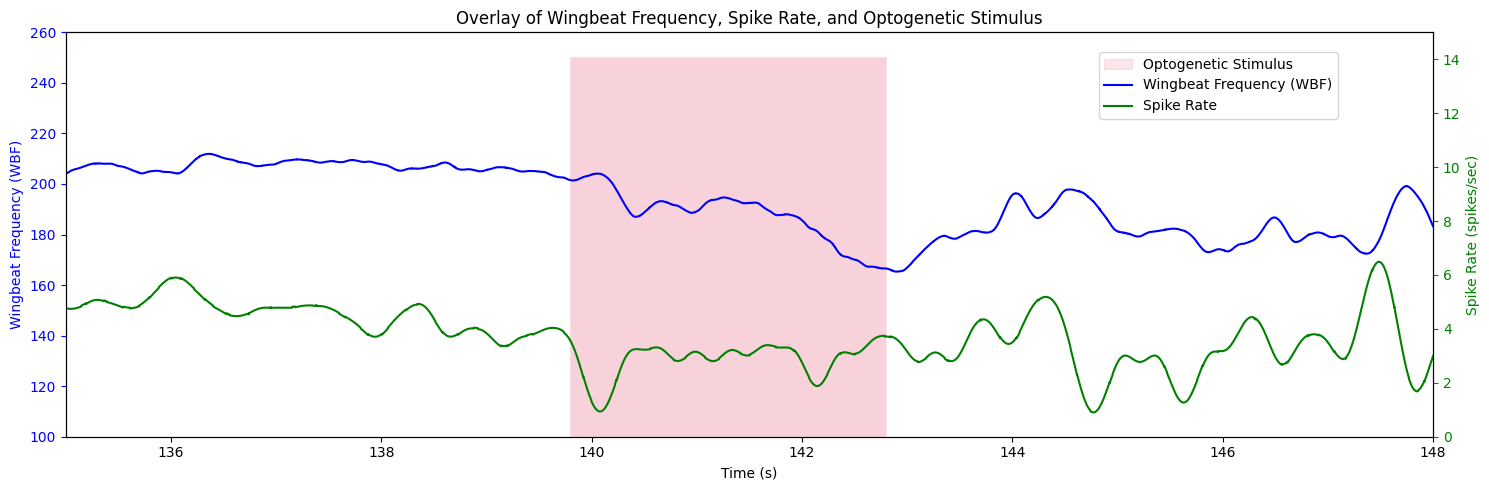

In [68]:
# Function to plot Wingbeat Frequency (WBF), spike rate, and optogenetic stimulus with different y-axes
def plot_wbf_spike_rate_stimulus(time_in_seconds, data4_normalized, spike_rate, transformed_data7, xlimit=(135, 148)):
    fig, ax1 = plt.subplots(figsize=(15, 5))

    # Plot optogenetic stimulus (transformed_data7) in the background
    ax1.fill_between(time_in_seconds, 0, 250 * transformed_data7, color='crimson', alpha=0.1, label='Optogenetic Stimulus')

    # Plot Wingbeat Frequency (WBF) on the left y-axis
    ax1.plot(time_in_seconds, data4_normalized, color='blue', label='Wingbeat Frequency (WBF)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Wingbeat Frequency (WBF)', color='blue')
    ax1.tick_params(axis='y', colors='blue')
    ax1.set_ylim(100, 260)  # Adjusting the y-axis limits for WBF
    ax1.set_xlim(xlimit)  # Set the x-axis limit based on the input range

    # Create a second y-axis for the spike rate
    ax2 = ax1.twinx()  # Create a second axis sharing the same x-axis
    ax2.plot(time_in_seconds, spike_rate, label='Spike Rate', color='green')
    ax2.set_ylabel('Spike Rate (spikes/sec)', color='green')
    ax2.tick_params(axis='y', colors='green')
    ax2.set_ylim(0, 15)  # Adjusting the y-axis limits for spike rate

    # Adding a title and a legend for better visualization
    plt.title('Overlay of Wingbeat Frequency, Spike Rate, and Optogenetic Stimulus')

    # Add a combined legend for both y-axes
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))

    # Adjust the layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example function call (assuming the required variables are available)
plot_wbf_spike_rate_stimulus(time_in_seconds, data4_normalized, spike_rate, transformed_data7, xlimit=(135, 148))


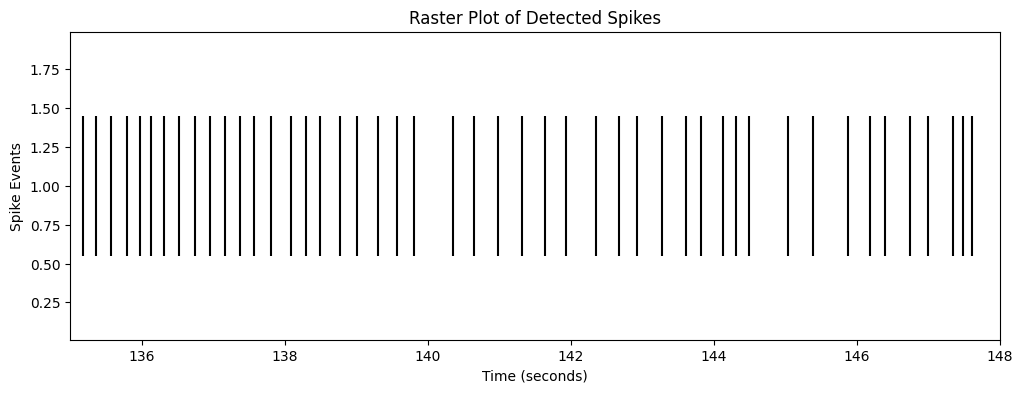

In [69]:
# Section 5, raster plot of detected spikes
def plot_raster(spike_count, sampling_rate, xlimit=None):
    # Convert spike indices to time in seconds
    spike_times = np.where(spike_count == 1)[0] / sampling_rate

    # Create the raster plot
    plt.figure(figsize=(12, 4))
    
    # Plot each spike as a vertical line
    plt.eventplot(spike_times, orientation='horizontal', linelengths=0.9, color='black')

    # Labeling the plot
    plt.xlabel('Time (seconds)')
    plt.ylabel('Spike Events')
    plt.title('Raster Plot of Detected Spikes')
    
    # If xlimit is provided, apply it
    if xlimit:
        plt.xlim(xlimit)

    # Display the plot
    plt.show()

# Example usage: Plot raster for time range [a, b]
plot_raster(spike_count, sampling_rate, xlimit=xlimit)